# General calibration of cosmic-ray neutron sensors to estimate soil water content

In [1]:
import pandas as pd
import os
from io import StringIO
import numpy as np
import subprocess as sp
import matplotlib.pyplot as plt
import glob
import cosmicsense as cs
import datetime as dt
from scipy.optimize import minimize_scalar, minimize
#from scipy import interpolate
#from fluids.atmosphere import ATMOSPHERE_1976
from matplotlib.ticker import AutoMinorLocator
import warnings
warnings.filterwarnings("ignore")

## General calibration

### Read calibration dataset

Combination of calibration data from four datasets published in ESSD (Fersch et al. 2020, Bogena et al. 2022, Heistermann et al. 2022, Heistermann et al. 2023).

In [7]:
cals = pd.read_csv("data/caldata.csv", sep=";", comment="#")

### Fitting $N_0$

In [8]:
cals2cal = cals.loc[cals.tocal]
def mae_n0(n0,cals2cal):
    errors = np.array([])
    cals2cal = cals2cal.set_index(np.arange(len(cals2cal)))
    for i in cals2cal.index:
        x = cs.core.n_to_theta_desilets(cals2cal.loc[i,"Nscaled"], n0, rhob=cals2cal.loc[i,"bd"])
        #error = np.abs(cals2cal.loc[i,"thetaeff"] - x)
        error = cals2cal.loc[i,"thetaeff"] - x
        if np.isfinite(error):
            errors = np.append(errors, error )
    return np.mean(np.abs(errors))

In [9]:
result = minimize_scalar(mae_n0, args=(cals2cal))
result

     fun: 0.07548539034469519
 message: '\nOptimization terminated successfully;\nThe returned value satisfies the termination criteria\n(using xtol = 1.48e-08 )'
    nfev: 34
     nit: 16
 success: True
       x: 2305.911957556905

### Confidence interval of $N_0$ via bootstrapping 

In [10]:
tmp = cals2cal.index#[calix]
np.random.seed(40)
calixes = np.random.choice(tmp, (500, len(tmp)), replace=True)
n0s = []
n0s = np.array([ minimize_scalar(mae_n0, args=(cals2cal.loc[calixe])).x for calixe in calixes ])
n0slci, n0suci = np.quantile(n0s, [0.025,0.975])
n0smean = n0s.mean()

In [11]:
print("Standard deviation of N0:", (n0suci - n0slci)/2/1.96)

Standard deviation of N0: 14.636408349001474


### Plot

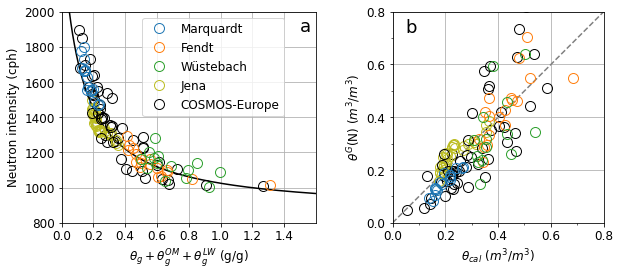

In [12]:
colors = plt.cm.nipy_spectral(np.linspace(0,1,len(np.unique(cals.id))))
np.random.shuffle(colors)
loccolors = {}
for i, id in enumerate(np.unique(cals.id)):
    loccolors[id] = colors[i]
    
avgn0 = result["x"]

colMQ = "tab:blue"
colFENDT = "tab:orange"
colWUEST = "tab:green"
colJEC = "tab:olive"

plt.rc('font', **{'size'   : 12})
fig, ax = plt.subplots(figsize=(9,4), ncols=2)
ax = ax.ravel()

plt.sca(ax[1])
ax[1].set_aspect("equal")

plt.plot([0,1], [0,1], ms=0, color="grey", ls="--", label="_tmp")
for i in cals.index:
    color = "black"
    marker="o"
    if "MQ" in cals.loc[i,"id"]:
        color=colMQ
    if "JEC" in cals.loc[i,"id"]:
        color=colJEC
    if "FENDT" in cals.loc[i,"id"]:
        color=colFENDT
    if "WUEST" in cals.loc[i,"id"]:
        color=colWUEST

    tmp =  float(cals.loc[i,"Nscaled"])

    tmptheta = cs.core.n_to_theta_desilets(float(cals.loc[i,"Nscaled"]), n0=avgn0,
                                           rhob=cals.loc[i,"bd"])

    plt.plot(cals.loc[i,"theta"], tmptheta-cals.loc[i,"weq"], lw=0, ms=10, 
             marker=marker, mfc="None", mec=color)

plt.grid()
plt.xlim(0., .79)    
plt.ylim(0., .79)
plt.xticks(np.arange(0,1,0.2))
minor_locator = AutoMinorLocator(2)
ax[1].xaxis.set_minor_locator(minor_locator)
plt.yticks(np.arange(0,1,0.2))
ax[1].yaxis.set_minor_locator(minor_locator)
plt.xlabel(r"$\theta_{cal}$ ($m^3/m^3$)")
plt.ylabel(r"$\theta^G$(N) ($m^3/m^3$)")
plt.text(0.05, 0.72, "b", fontsize=18)

plt.sca(ax[0])
narr = np.arange(900,2500)

plt.plot(cs.core.n_to_theta_desilets(narr, n0=avgn0, rhob=1000.), narr, color="black")

arrN = np.array([])
arrTheff = np.array([])
for i in cals.index:
    color="black"
    marker="o"
    if "MQ" in cals.loc[i,"id"]:
        color=colMQ
    if "JEC" in cals.loc[i,"id"]:
        color=colJEC
    if "FENDT" in cals.loc[i,"id"]:
        color=colFENDT
    if "WUEST" in cals.loc[i,"id"]:
        color=colWUEST
    mfc="None"

    tmp = cals.loc[i,"Nscaled"]
    theffg = cals.loc[i,"thetaeff"]/(cals.loc[i, "bd"]/1000.)
    plt.plot(theffg, tmp, ms=10, marker=marker, mfc=mfc, mec=color)
    arrN = np.append(arrN, tmp)
    arrTheff = np.append(arrTheff, theffg)

plt.xlabel(r"$\theta_g + \theta_g^{OM} + \theta_g^{LW}$ (g/g)")
plt.ylabel("Neutron intensity (cph)")
plt.grid()

plt.xlim(0, 1.6)
plt.ylim(800, 2000)
plt.xticks(np.arange(0,1.6,0.2))
plt.text(1.5, 1890, "a", fontsize=18)


legend_elements = [plt.Line2D([0], [0], marker="o", ms=10, mec="tab:blue", mfc="None", lw=0, label="Marquardt"),
                   plt.Line2D([0], [0], marker="o", ms=10, mec="tab:orange", mfc="None", lw=0, label="Fendt"),
                   plt.Line2D([0], [0], marker="o", ms=10, mec="tab:green", mfc="None", lw=0, label="Wüstebach"),
                   plt.Line2D([0], [0], marker="o", ms=10, mec="tab:olive", mfc="None", lw=0, label="Jena"),
                   plt.Line2D([0], [0], marker="o", ms=10, mec="black", mfc="None", lw=0, label="COSMOS-Europe")]

plt.legend(handles=legend_elements, loc="upper right", fontsize=12, frameon=True, bbox_to_anchor=(0.9,1) )


plt.tight_layout()

plt.savefig("figs/calibration.pdf", dpi=300)

## Error propagation

### General calibration

$\theta = \Big( \frac{a_0}{f_p \cdot f_h \cdot f_i \cdot f_b \cdot f_s \cdot \frac{N}{N_0} - a_1}-a_2
-\theta_{g}^{SOM}-\theta_{g}^{LW} \Big)\cdot\frac{\varrho_b}{\varrho_w}$

- $N$: raw count rate
- $f_p$, $f_h$, $f_i$: $\phi$-correction factors
- $f_b = \frac{1}{1 - m_b \cdot 0.009}$ (biomass correction factor, $m_b$: aboveground dry biomass)
- $f_s = \frac{N_{calibrator}}{N}$: sensitivity correction factor for sensor
- $\theta_g^{SOM}= s \cdot 0.556$ ($s$: soil organic matter content in g/g)

For simplicity, we treat N as $\phi$-corrected, and insert the specs for $f_b$ and $\theta_g^{SOM}$ :

$\theta(N) = \Big( \frac{a_0}{\frac{f_s \cdot N}{N_0 \cdot (1 - m_b \cdot 0.009)}- a_1}-a_2
- s \cdot 0.556 -\theta_{g}^{LW} \Big)\cdot\frac{\varrho_b}{\varrho_w}$

That way, the standard deviation of $\theta(N)$ can be approximated as 

$\sigma_{\theta(N)} = \sqrt{  
                        \frac{\partial \theta}{\partial f_s}^2 \sigma_{f_s}^2 +
                        \frac{\partial \theta}{\partial m_b}^2 \sigma_{m_b}^2 +
                        \frac{\partial \theta}{\partial s}^2 \sigma_{s}^2 +
                        \frac{\partial \theta}{\partial N}^2   \sigma_{N}^2   +
                        \frac{\partial \theta}{\partial N_0}^2 \sigma_{N_0}^2 +
                        \frac{\partial \theta}{\partial \theta_{LW}}^2 \sigma_{\theta_{LW}}^2 +
                        \frac{\partial \theta}{\partial \rho_b}^2 \sigma_{\rho_b}^2
                        }$

$\frac{\partial \theta}{\partial N} = \frac{111.111 \cdot a_0 \cdot \rho_b \cdot (m_b - 111.111) \cdot f_s \cdot N_0}{\rho_w \cdot (a_1 \cdot (m_b - 111.111) \cdot  N_0 + 111.111 \cdot f_s \cdot N)^2}$

$\frac{\partial \theta}{\partial N_0} = \frac{111.111 \cdot a_0 \cdot \rho_b \cdot (m_b - 111.111) \cdot f_s \cdot N}{\rho_w \cdot (a_1 \cdot (m_b - 111.111) \cdot  N_0 + 111.111 \cdot f_s \cdot N)^2}$

$\frac{\partial \theta}{\partial f_s} = \frac{111.111 \cdot a_0 \cdot \rho_b \cdot (m_b - 111.111) \cdot N \cdot N_0}{\rho_w \cdot (a_1 \cdot (m_b - 111.111) \cdot  N_0 + 111.111 \cdot f_s \cdot N)^2}$

$\frac{\partial \theta}{\partial m_b} = \frac{0.009 \cdot a_0 \cdot \rho_b \cdot f_s \cdot N \cdot N_0}{(\rho_w \cdot (a_1 \cdot N_0 \cdot (0.009 \cdot m_b - 1) + f_s \cdot N)^2)}$

$\frac{\partial \theta}{\partial \rho_b} = \Big( \frac{a_0}{\frac{f_s \cdot N}{N_0 \cdot (1 - m_b \cdot 0.009)}- a_1}-a_2
- s \cdot 0.556 -\theta_{g}^{LW} \Big) \cdot \frac{1}{\varrho_w}$

$\frac{\partial \theta}{\partial s} = -0.556 \cdot \frac{\rho_b}{\rho_w}$

$\frac{\partial \theta}{\partial \theta_g^{LW}} = - \frac{\rho_b}{\rho_w}$

In [13]:
def get_N(N0=None, thc=None, rhob=None, a0=0.0808, a1=0.372, a2=0.115, rhow=1000.):
    return N0 * ( (a0 / (thc * rhow / rhob + a2)) + a1)

In [14]:
def N_error(N, a=24):
    return (np.sqrt(N*a) / a)

In [15]:
def dth_dN(N=None, N0=None, fs=None, rhob=None, mb=None, som=None, lw=None, a0=None, a1=None, a2=None, rhow=None):
    return 111.111 * a0 * rhob * (mb - 111.111) * fs * N0 / (rhow * (a1 * (mb-111.111) * N0 + 111.111 * fs * N )**2)

def dth_dN0(N=None, N0=None, fs=None, rhob=None, mb=None, som=None, lw=None, a0=None, a1=None, a2=None, rhow=None):
    return 111.111 * a0 * rhob * (mb - 111.111) * fs * N / (rhow * (a1 * (mb-111.111) * N0 + 111.111 * fs * N )**2)

def dth_dfs(N=None, N0=None, fs=None, rhob=None, mb=None, som=None, lw=None, a0=None, a1=None, a2=None, rhow=None):
    return 111.111 * a0 * rhob * (mb - 111.111) * N * N0 / (rhow * (a1 * (mb-111.111) * N0 + 111.111 * fs * N )**2)

def dth_dmb(N=None, N0=None, fs=None, rhob=None, mb=None, som=None, lw=None, a0=None, a1=None, a2=None, rhow=None):
    return 0.009 * a0 * rhob * fs * N * N0 / (rhow * (a1 * N0 * (0.009 * mb - 1) + fs * N)**2)

def dth_drhob(N=None, N0=None, fs=None, rhob=None, mb=None, som=None, lw=None, a0=None, a1=None, a2=None, rhow=None):
    return ((a0 / (fs * N / (N0 * (1. - 0.009*mb)) - a1)) - a2 - 0.556 * som - lw) / rhow

def dth_dsom(N=None, N0=None, fs=None, rhob=None, mb=None, som=None, lw=None, a0=None, a1=None, a2=None, rhow=None):
    return -0.556 * rhob / rhow

def dth_dlw(N=None, N0=None, fs=None, rhob=None, mb=None, som=None, lw=None, a0=None, a1=None, a2=None, rhow=None):
    return -rhob / rhow


def sigma_th(pars, sigmas):
    return np.sqrt( 
              dth_dfs(**pars)**2   * sigmas["fs"]**2   + \
              dth_dN(**pars)**2    * sigmas["N"]**2    + \
              dth_dN0(**pars)**2   * sigmas["N0"]**2   + \
              dth_dmb(**pars)**2   * sigmas["mb"]**2   + \
              dth_drhob(**pars)**2 * sigmas["rhob"]**2 + \
              dth_dsom(**pars)**2  * sigmas["som"]**2  + \
              dth_dlw(**pars)**2   * sigmas["lw"]**2
    )

In [16]:
def get_sigma_fs(fs, Ncal, a=24):
    """Error of fs for a given collocation interval a and a calibrator neutron intensity of Ncal
    
    The relative error of the target variable is the difference between the relative error 
    of the enumerator and the relative error of the denominator.
    """
    return fs * np.sqrt((1+fs)/(Ncal*a))

In [17]:
def update_sigma_th(N_at_fc, N2, pars, sigmas):
    pars["N"] = N_at_fc
    sigmas["N"] = N_error(pars["N"])
    sigma1 = sigma_th(pars, sigmas)
    pars["N"] = N2
    sigmas["N"] = N_error(pars["N"])
    sigma2 = sigma_th(pars, sigmas)
    return sigma1, sigma2

In [18]:
gcols = "#641e16", "#c0392b", "#d98880"
lcols = "#154360", "#2980b9", "#7fb3d5"

#### Plot

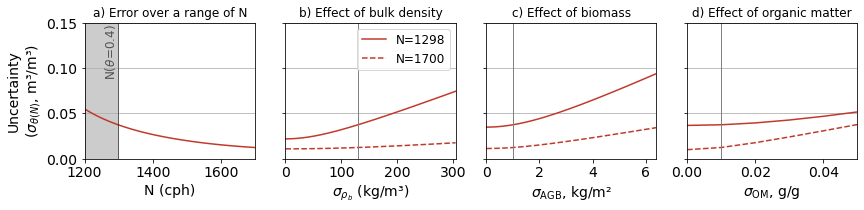

In [19]:
rhob_ = 1300.
sigma_rhob = 130
mb_ = 2
sigma_mb = 1
som_ = 0.06
sigma_som = 0.01
lw_ = 0.02
sigma_lw = 0.002
# Example: fs=2 --> half the sensitivity of the calibrator
fs_ = 1.
sigma_fs = get_sigma_fs(fs_, 1400, 48) # two day collocation
sigma_N0 = (n0suci - n0slci) / 2. / 1.96

# measured neutron intensities (scaled range)
N1, N2 = 1200, 1700

pars = {"N0":avgn0, "fs":fs_, "rhob":rhob_, "mb":mb_, "som":som_, "lw":lw_,
        "a0":0.0808, "a1":0.372, "a2":0.115, "rhow":1000.}

fc = 0.4
N_at_fc = get_N(N0=avgn0, thc=fc, rhob=rhob_)

sigmas = {"N0":sigma_N0, "fs":sigma_fs, "mb": sigma_mb, "rhob":sigma_rhob, 
          "som":sigma_som, "lw":sigma_lw}
    
# N
Nrange = np.linspace(N1, N2,100)
pars["N"] = Nrange.copy()
sigmas["N"] = N_error(pars["N"])
sigma_th_N = sigma_th(pars, sigmas)

# sigma(rhob)
sigrhobrange = np.arange(0, 305, 0.1)
sigmas["rhob"] = sigrhobrange
sigma_th_sigrhob1, sigma_th_sigrhob2 = update_sigma_th(N_at_fc, N2, pars, sigmas)

# sigma(m_b)
sigmas["rhob"] = sigma_rhob # reset
mbrange = np.arange(0, 6.5, 0.1)
sigmas["mb"] = mbrange
sigma_th_mb1, sigma_th_mb2 = update_sigma_th(N_at_fc, N2, pars, sigmas)

# sigma(som)
somrange = np.arange(0, 0.06, 0.01)
sigmas["som"] = somrange
sigmas["mb"] = sigma_mb # reset
sigma_th_som1, sigma_th_som2 = update_sigma_th(N_at_fc, N2, pars, sigmas)

plt.rc('font', **{'size'   : 14})

fig, ax = plt.subplots(1,4, figsize=(12,3), sharey=True)
ax = ax.ravel()

plt.sca(ax[0])
plt.fill_betweenx(y=[0,10], x1=N1*0.8, x2=N_at_fc, color="black", alpha=0.2)
plt.plot(Nrange, sigma_th_N, color=gcols[1])
plt.xlabel(r"N (cph)")
plt.ylabel(r"$(\sigma_{\theta(N)}$, m³/m³)")
plt.axvline(N_at_fc, color="black", lw=0.5)
plt.xlim(N1,N2)
plt.ylim(0,0.15)
plt.grid(axis="y")

plt.sca(ax[1])
plt.plot(sigrhobrange, sigma_th_sigrhob1, color=gcols[1], label="N=%d" % (N_at_fc))
plt.plot(sigrhobrange, sigma_th_sigrhob2, color=gcols[1], ls="--", label="N=%d" % (N2))
plt.legend(fontsize=12)
plt.xlabel(r"$\sigma_{\rho_b}$ (kg/m³)")
plt.axvline(sigma_rhob,ls="-", lw=1, color="grey")
plt.grid(axis="y")
plt.xlim(sigrhobrange.min(), sigrhobrange.max())

plt.sca(ax[2])
plt.plot(mbrange, sigma_th_mb1, color=gcols[1], label="N1=%d" % (N_at_fc))
plt.plot(mbrange, sigma_th_mb2, color=gcols[1], ls="--", label="N2=%d" % (N2))
plt.xlabel(r"$\sigma_{\mathregular{AGB}}$, kg/m²")
plt.axvline(sigma_mb, ls="-", lw=1, color="grey")
plt.grid(axis="y")
plt.xlim(mbrange.min(), mbrange.max())

plt.sca(ax[3])
plt.plot(somrange, sigma_th_som1, color=gcols[1], label="N1=%d" % (N_at_fc))
plt.plot(somrange, sigma_th_som2, color=gcols[1], ls="--", label="N2=%d" % (N2))
plt.xlabel(r"$\sigma_{\mathregular{OM}}$, g/g")
plt.axvline(sigma_som, ls="-", lw=1, color="grey")
plt.grid(axis="y")
plt.xlim(somrange.min(), somrange.max())

ax[0].text(N_at_fc, plt.ylim()[1]*0.99, r"N($\theta$=0.4)", rotation=90,
        horizontalalignment="right", verticalalignment="top", fontsize=12, color="black", alpha=0.6)

plt.tight_layout()

ax[0].set_title(r"a) Error over a range of N", fontsize=12)
ax[1].set_title(r"b) Effect of bulk density", fontsize=12)
ax[2].set_title(r"c) Effect of biomass", fontsize=12)
ax[3].set_title(r"d) Effect of organic matter", fontsize=12)
ax[0].text(993,0.075, "Uncertainty", rotation=90, verticalalignment="center", horizontalalignment="center")

plt.savefig("figs/general-calibration.pdf", dpi=300, facecolor="white")

### Local calibration

$\theta(N) = \left (\frac{a_0}{ \frac{N}{N_c} \cdot \frac{a_0}{\theta_{c} \cdot \frac{\rho{_w}}{\rho{_b}}+a_2} +a_1 \cdot (\frac{N}{N_c}-1)} - a_2 \right) \cdot \frac{\rho_{b}}{\rho_{w}}$

where $N_c$ and $\theta_{c}$ are count rate and measured SWC (volumetric) at the calibration date, $N$ is the $\phi$-corrected count rate.

Approximate $\sigma_{\theta}$ by
 
$\sigma_{\theta(N)} = \sqrt{  
                        \frac{\partial \theta}{\partial N}^2 \sigma_{N}^2 +
                        \frac{\partial \theta}{\partial N_c}^2 \sigma_{N_c}^2 +
                        \frac{\partial \theta}{\partial \theta_c}^2 \sigma_{\theta_c}^2 +
                        \frac{\partial \theta}{\partial \rho_b}^2 \sigma_{\rho_b}^2
                        }$

$\frac{\partial \theta}{\partial N} = -\frac{a_0 \cdot \rho_b \cdot N_c \cdot (a_2 \cdot \rho_b + \theta_c \cdot \rho_{w}) \cdot (a_0 \cdot \rho_b + a_2 \cdot a_1 \cdot \rho_b + a_1 \cdot \theta_c \cdot \rho_w)}{\rho_w \cdot (a_2 \cdot a_1 \cdot \rho_b \cdot (N_c - N) - a_0 \cdot \rho_b \cdot N + a_1  \cdot \theta_c \cdot \rho_w \cdot (N_c - N) )^2}$

$\frac{\partial \theta}{\partial N_c} = \frac{a_0 \cdot \rho_b \cdot N \cdot (a_2 \cdot \rho_b + \theta_c \cdot \rho_w) \cdot (a_0 \cdot \rho_b + a_2 \cdot a_1 \cdot \rho_b + a_1 \cdot \theta_c \cdot \rho_w)}{\rho_w \cdot (a_1 \cdot (N - N_c) \cdot (a_2 \cdot \rho_b + \theta_c \cdot \rho_w) + a_0 \cdot \rho_b \cdot N)^2}$

$\frac{\partial \theta}{\partial \theta_c} = \frac{a_0^2 \cdot \rho_b^2 \cdot N \cdot N_c}{(a_1 \cdot (N - N_c) \cdot (a2 \cdot \rho_b + \rho_w \cdot \theta_c) + a_0 \cdot \rho_b \cdot N)^2}$

$\frac{\partial \theta}{\partial \rho_b} = \frac{((a_1 \cdot (N - N_c) (a_2 \cdot \rho_b + \theta_c \cdot \rho_w) + a_0 \cdot N \cdot \rho_b) (a_0 \cdot N_c (a_2 \cdot \rho_b + \theta_c \cdot \rho_w) - a_2 \cdot (a_1 \cdot (N - N_c) \cdot (a_2 \cdot \rho_b + \theta_c \cdot \rho_w) + a_0 \cdot N \cdot \rho_b)) - a_0^2 \cdot N_c \cdot N \cdot \theta_c \cdot \rho_w \cdot \rho_b)}{\rho_w \cdot (a_1 \cdot (N - Nc) \cdot (a_2 \cdot \rho_b + \theta_c \cdot \rho_w) + a_0 \cdot N \cdot \rho_b)^2}$

In [20]:
def dth_dN_eff(N=None, Nc=None, rhob=None, thc=None, a0=None, a1=None, a2=None, rhow=None):
    return -a0 * rhob * Nc * (a2 * rhob + thc * rhow) * (a0 * rhob + a2 * a1 * rhob + a1 * thc * rhow) / \
           (rhow * (a2 * a1 * rhob * (Nc - N) - a0 * rhob * N + a1 * thc * rhow * (Nc - N))**2)

def dth_dNc_eff(N=None, Nc=None, rhob=None, thc=None, a0=None, a1=None, a2=None, rhow=None):
    return a0 * rhob * N * (a2 * rhob + thc * rhow) * (a0 * rhob + a2 * a2 * rhob + a1 * thc * rhow) / \
           (rhow * (a1 * (N - Nc) * (a2 * rhob + thc * rhow) + a0 * rhob * N)**2 )

def dth_dthc_eff(N=None, Nc=None, rhob=None, thc=None, a0=None, a1=None, a2=None, rhow=None):
    return a0**2 * rhob**2 * N * Nc / ( (a1 * (N - Nc) * (a2 * rhob + rhow * thc) + a0 * rhob * N)**2 )

def dth_drhob_eff(N=None, Nc=None, rhob=None, thc=None, a0=None, a1=None, a2=None, rhow=None):
    return ( (a1 * (N-Nc) * (a2*rhob+thc*rhow) + a0*N*rhob) \
              * (a0 * Nc * (a2*rhob + thc*rhow) - a2 * (a1*(N-Nc)*(a2*rhob + thc*rhow) + a0*N*rhob) ) \
              - a0**2 * Nc * N * thc * rhow * rhob) / \
              (rhow * (a1 * (N-Nc) * (a2*rhob + thc*rhow) + a0*N*rhob)**2 )

def sigma_th_eff(pars, sigmas):
    return np.sqrt( 
              dth_dN_eff(**pars)**2    * sigmas["N"]**2   + \
              dth_dNc_eff(**pars)**2   * sigmas["Nc"]**2  + \
              dth_dthc_eff(**pars)**2  * sigmas["thc"]**2 + \
              dth_drhob_eff(**pars)**2 * sigmas["rhob"]**2
    )

In [21]:
def get_pars_n_sigmas_local(N0, N1, N2, thc, rhob, fs, sigma_thc, sigma_rhob, fc=0.4):
    pars = {"rhob":rhob, "thc":thc, "a0":0.0808, "a1":0.372, "a2":0.115, "rhow":1000.}
    # remove sensitivity scaling to obtain errors
    pars["Nc"] = get_N(N0, thc, rhob)/fs
    pars["N"] = np.linspace(N1,N2,100)/fs
    sigmas = {"Nc":N_error(pars["Nc"])*fs, "thc":sigma_thc, "rhob":sigma_rhob}
    sigmas["N"] = N_error(pars["N"])*fs
    return pars, sigmas

def get_pars_n_sigmas_general(N0, N1, N2, rhob, fs, mb, som, lw, sigma_N0, sigma_rhob, sigma_mb, 
                              sigma_som, sigma_lw, fc=0.4):

    pars_general = {"N0":N0, "fs":fs, "rhob":rhob, "mb":mb, "som":som, "lw":lw,
                    "a0":0.0808, "a1":0.372, "a2":0.115, "rhow":1000.}

    sigmas_general = {"N0":sigma_N0, "fs":get_sigma_fs(fs, 1400, 48), "mb": sigma_mb, "rhob":sigma_rhob, 
                      "som":sigma_som, "lw":sigma_lw}
    
    # remove sensitivity scaling to obtain errors
    pars_general["N"] = np.linspace(N1,N2,100)/fs
    sigmas_general["N"] = N_error(pars_general["N"])*fs
    sigma_th_N_general = sigma_th(pars_general, sigmas_general)
    
    return pars_general, sigmas_general

# decoration
def decorate(ax, fc, rhob, ylabel=r"($\sigma_{\theta(N)}$, m³/m³)", ymax=0.2):
    N_at_fc=get_N(N0=avgn0, thc=fc, rhob=rhob)
    plt.fill_betweenx(y=[0,ymax], x1=N1*0.8, x2=N_at_fc, color="black", alpha=0.2)
    ax.axvline(N_at_fc, lw=0.5, color="black")
    plt.xlabel(r"N (cph)")
    plt.xlim(N1,N2)
    plt.ylim(0,ymax)
    plt.ylabel(ylabel)
    xtxt = np.mean(plt.xlim())
    ytxt = plt.ylim()[-1]
    plt.legend(fontsize=10)
    plt.grid(axis="y")

gcols = "#641e16", "#c0392b", "#d98880"
lcols = "#154360", "#2980b9", "#7fb3d5"

#### Plot

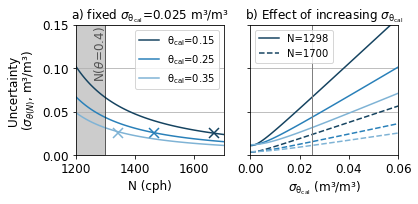

In [22]:
# LOCAL
# plot 1: effect of calibration conditions
# plot 2: effect of calibration error

fc=0.4

# ALL
rhob_ = 1300.
sigma_rhob = 100
N1, N2 = 1200, 1700

sigma_thc_v2 = 0.025


plt.rc('font', **{'size'   : 12})
fig, ax = plt.subplots(1,2, figsize=(6,3), sharey=True)
ax = ax.ravel()
ymax = 0.2

# --------------------------------
# PLOT 1
plt.sca(ax[0])

for i, thc_ in enumerate([0.15,0.25,0.35]):
    pars, sigmas = get_pars_n_sigmas_local(N0=avgn0, N1=N1, N2=N2, thc=thc_,
                                              rhob=rhob_, fs=1., sigma_thc=sigma_thc_v2, sigma_rhob=sigma_rhob)
    sigma_th_N = sigma_th_eff(pars, sigmas)
    
    pl = plt.plot(pars["N"], sigma_th_N, color=lcols[i], label=r"$\mathregular{\theta_{cal}}$=%.2f" % thc_)
    plt.plot(pars["Nc"], sigma_thc_v2, "kx", mew=1.5, color=lcols[i], ms=10, label=r"_dummy")


decorate(ax[0], fc=fc, rhob=rhob_)

# --------------------------------
# PLOT 2

plt.sca(ax[1])

thcrange = np.arange(0, 0.062, 0.001)
sigmas["thc"] = thcrange
sigmas["rhob"] = sigma_rhob #reset

for i, thc_ in enumerate([0.15,0.25,0.35]):
    label1="N=%d" % N_at_fc
    label2="N=%d" % 1700
    if not i==0:
        label1="_dummy"
        label2="_dummy"
    pars["thc"] = thc_
    pars["Nc"] = get_N(avgn0, pars["thc"], rhob_)

    N_at_fc = get_N(N0=avgn0, thc=fc, rhob=rhob_)
    pars["N"] = N_at_fc
    sigmas["N"] = N_error(N_at_fc)
    sigma_th_thc = sigma_th_eff(pars, sigmas)
    plt.plot(thcrange, sigma_th_thc, color=lcols[i], label=label1)

    pars["N"] = N2
    sigmas["N"] = N_error(N2)
    sigma_th_thc = sigma_th_eff(pars, sigmas)
    plt.plot(thcrange, sigma_th_thc, color=lcols[i], ls="--", label=label2)
plt.legend(fontsize=10)


plt.xlabel(r"$\sigma_{\mathregular{\theta_{cal}}}$ (m³/m³)")
plt.axvline(sigma_thc_v2,ls="-", lw=1, color="grey")
plt.grid(axis="y")
plt.xlim(thcrange.min(), 0.06)
plt.xticks([0,0.02, 0.04, 0.06])

plt.ylim(0,0.15)

ax[0].text(N_at_fc+5, plt.ylim()[1]*0.99, r"N($\theta$=0.4)", rotation=90,
        horizontalalignment="right", verticalalignment="top", fontsize=12, color="black", alpha=0.6)

ax[0].set_title(r"a) fixed $\sigma_{\mathregular{\theta_{cal}}}$=%.3f m³/m³" % sigma_thc_v2, fontsize=12)
ax[1].set_title(r"b) Effect of increasing $\sigma_{\mathregular{\theta_{cal}}}$", fontsize=12)
ax[0].text(990,0.075, "Uncertainty", rotation=90, verticalalignment="center", horizontalalignment="center")


plt.tight_layout()

plt.savefig("figs/local-calibration.pdf")

### Plot for direct comparision of local vs. general

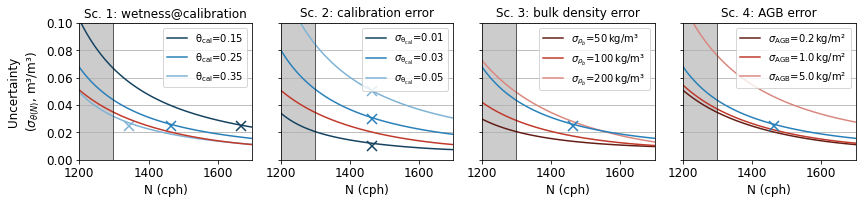

In [23]:
# 4 scenarios
# scenario 1: effect of calibration date
# scenario 2: effect of bulk density error
# scenario 3: effect of biomass error
# scenario 4: effect of calibration theta error

fc=0.4

# ALL
rhob_ = 1300.
sigma_rhob = 130
N1, N2 = 1200, 1700

# LOCAL
thcs = [0.15, 0.25, 0.35]
sigma_thc = 0.025

# GENERAL
fs_ = 1.
sigma_fs = get_sigma_fs(fs_, 1400, 48)
mb_ = 2
sigma_mb = 0.2
som_ = 0.06
sigma_som = 0.01
lw_ = 0.02
sigma_lw = 0.002
N0 = avgn0
sigma_N0 = (n0suci - n0slci) / 2. / 1.96
    
plt.rc('font', **{'size'   : 12})
fig, ax = plt.subplots(1,4, figsize=(12,3), sharey=True)
ax = ax.ravel()
ymax = 0.2

# --------------------------------
# SCENARIO 1
plt.sca(ax[0])

for i, thc_ in enumerate(thcs):
    pars, sigmas = get_pars_n_sigmas_local(N0=avgn0, N1=N1, N2=N2, thc=thc_,
                                              rhob=rhob_, fs=fs_, sigma_thc=sigma_thc, sigma_rhob=sigma_rhob)
    sigma_th_N = sigma_th_eff(pars, sigmas)
    
    pl = plt.plot(pars["N"]*fs_, sigma_th_N, color=lcols[i], label=r"$\mathregular{\theta_{cal}}$=%.2f" % thc_)
    plt.plot(pars["Nc"]*fs_, sigma_thc, "kx", mew=1.5, color=lcols[i], ms=10, label=r"_dummy")


pars_general, sigmas_general = get_pars_n_sigmas_general(N0=avgn0, N1=N1, N2=N2, rhob=rhob_, fs=fs_, 
                                                         mb=mb_, som=som_, lw=lw_, sigma_N0=sigma_N0, 
                                                         sigma_rhob=sigma_rhob, sigma_mb=sigma_mb,
                                                         sigma_som=sigma_som, sigma_lw=sigma_lw)
sigma_th_N_general = sigma_th(pars_general, sigmas_general)
plt.plot(pars_general["N"]*fs_, sigma_th_N_general, color=gcols[1], label="_dummy")
decorate(ax[0], fc=fc, rhob=rhob_)

# --------------------------------
# SCENARIO 3
plt.sca(ax[2])

for i, sigma_rhob_ in enumerate([50, 100, 200]):
    pars_general, sigmas_general = get_pars_n_sigmas_general(N0=avgn0, N1=N1, N2=N2, rhob=rhob_, fs=fs_, 
                                                             mb=mb_, som=som_, lw=lw_, sigma_N0=sigma_N0, 
                                                             sigma_rhob=sigma_rhob_, sigma_mb=sigma_mb,
                                                             sigma_som=sigma_som, sigma_lw=sigma_lw)
    sigma_th_N_general = sigma_th(pars_general, sigmas_general)
    plt.plot(pars_general["N"], sigma_th_N_general, color=gcols[i], label=r"$\sigma_{\rho_b}$=%d$\,$kg/m³" % sigma_rhob_)
    
pars, sigmas = get_pars_n_sigmas_local(N0=avgn0, N1=N1, N2=N2, thc=0.25,
                                          rhob=rhob_, fs=fs_, sigma_thc=sigma_thc, sigma_rhob=sigma_rhob_)
sigma_th_N = sigma_th_eff(pars, sigmas)
pl = plt.plot(pars["N"], sigma_th_N, color=lcols[1], label="_dummy")
plt.plot(pars["Nc"], sigma_thc, "kx", mew=1.5, color=lcols[1], ms=10, label=r"_dummy")

decorate(ax[2], fc=fc, rhob=rhob_, ylabel="")
plt.ylim(0,0.2)


# --------------------------------
# SCENARIO 4
plt.sca(ax[3])

for i, sigma_mb_ in enumerate([0.2, 1, 5]):
    pars_general, sigmas_general = get_pars_n_sigmas_general(N0=avgn0, N1=N1, N2=N2, rhob=rhob_, fs=fs_, 
                                                             mb=mb_, som=som_, lw=lw_, sigma_N0=sigma_N0, 
                                                             sigma_rhob=sigma_rhob, sigma_mb=sigma_mb_,
                                                             sigma_som=sigma_som, sigma_lw=sigma_lw)
    sigma_th_N_general = sigma_th(pars_general, sigmas_general)
    plt.plot(pars_general["N"], sigma_th_N_general, color=gcols[i], label=r"$\sigma_{\mathregular{AGB}}$=%.1f$\,$kg/m²" % sigma_mb_)
    
pars, sigmas = get_pars_n_sigmas_local(N0=avgn0, N1=N1, N2=N2, thc=0.25,
                                          rhob=rhob_, fs=fs_, sigma_thc=sigma_thc, sigma_rhob=sigma_rhob_)
sigma_th_N = sigma_th_eff(pars, sigmas)
pl = plt.plot(pars["N"], sigma_th_N, color=lcols[1], label="_dummy")
plt.plot(pars["Nc"], sigma_thc, "kx", mew=1.5, color=lcols[1], ms=10, label="_dummy")

decorate(ax[3], fc=fc, rhob=rhob_, ylabel="")

# --------------------------------
# SCENARIO 2
plt.sca(ax[1])

for i, sigma_thc_ in enumerate([0.01, 0.03, 0.05]):
    pars, sigmas = get_pars_n_sigmas_local(N0=avgn0, N1=N1, N2=N2, thc=0.25,
                                          rhob=rhob_, fs=fs_, sigma_thc=sigma_thc_, sigma_rhob=sigma_rhob_)
    sigma_th_N = sigma_th_eff(pars, sigmas)
    pl = plt.plot(pars["N"], sigma_th_N, color=lcols[i], label=r"$\sigma_{\mathregular{\theta_{cal}}}$=%.2f" % sigma_thc_)
    plt.plot(pars["Nc"], sigma_thc_, "kx", mew=1.5, color=lcols[i], ms=10, label=r"_dummy")


pars_general, sigmas_general = get_pars_n_sigmas_general(N0=avgn0, N1=N1, N2=N2, rhob=rhob_, fs=fs_, 
                                                         mb=mb_, som=som_, lw=lw_, sigma_N0=sigma_N0, 
                                                         sigma_rhob=sigma_rhob, sigma_mb=sigma_mb,
                                                         sigma_som=sigma_som, sigma_lw=sigma_lw)
sigma_th_N_general = sigma_th(pars_general, sigmas_general)
plt.plot(pars_general["N"], sigma_th_N_general, color=gcols[1], label="_dummy")
    

decorate(ax[1], fc=fc, rhob=rhob_, ylabel="")



plt.ylim(0,0.10)

ax[0].set_title(r"Sc. 1: wetness@calibration", fontsize=12)
ax[1].set_title(r"Sc. 2: calibration error", fontsize=12)
ax[2].set_title(r"Sc. 3: bulk density error", fontsize=12)
ax[3].set_title(r"Sc. 4: AGB error", fontsize=12)
ax[0].text(1010,0.05, "Uncertainty", rotation=90, verticalalignment="center", horizontalalignment="center")

plt.tight_layout()

plt.savefig("figs/scenarios.pdf", dpi=300, facecolor="white")